# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
import matplotlib.pyplot as plt
from getData import getData
import pandas as pd
import os

cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [14]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.6, 'CO2':201*1e-6/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [15]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.63},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.63},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [17]:
esM.add(fn.Conversion(esM=esM, name='Electrolyzer', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [18]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [19]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [20]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [22]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [23]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [24]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [25]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [27]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [28]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [29]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [30]:
esM.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(2.9510 sec)



 C:\Users\t.gross\Anaconda3\envs\oct2021\lib\site-packages\tsam\timeseriesaggregation.py:897: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


In [31]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.4235 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5288 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(4.0227 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.1144 sec)

Declaring shared potential constraint...
		(0.0059 sec)

Declaring linked component quantity constraint...
		(0.0010 sec)

Declaring commodity balances...
		(1.5646 sec)

		(0.0000 sec)

Declaring objective function...
		(0.6792 sec)

Either solver not selected or specified solver not available.

for SourceSinkModel ...    (1.2549sec)
for ConversionModel ...    (0.8911sec)


 c:\users\t.gross\documents\programming\github\fine\FINE\storage.py:1169: UserWarning:Charge and discharge at the same time for component Li-ion batteries
 c:\users\t.gross\documents\programming\github\fine\FINE\storage.py:1169: UserWarning:Charge and discharge at the same time for component Pumped hydro storage
 c:\users\t.gross\documents\programming\github\fine\FINE\storage.py:1169: UserWarning:Charge and discharge at the same time for component Salt caverns (biogas)
 c:\users\t.gross\documents\programming\github\fine\FINE\storage.py:1169: UserWarning:Charge and discharge at the same time for component Salt caverns (hydrogen)


for StorageModel ...       (3.2290sec)
for TransmissionModel ...  (2.3437sec)
		(7.7692 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

In [32]:
# Import the geopandas package for plotting the locations
import geopandas as gpd

 c:\users\t.gross\documents\programming\github\fine\FINE\IOManagement\standardIO.py:692: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\t.gross\documents\programming\github\fine\FINE\IOManagement\standardIO.py:692: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\t.gross\documents\programming\github\fine\FINE\IOManagement\standardIO.py:692: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\t.gross\documents\programming\github\fine\FINE\IOManagement\standardIO.py:692: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the

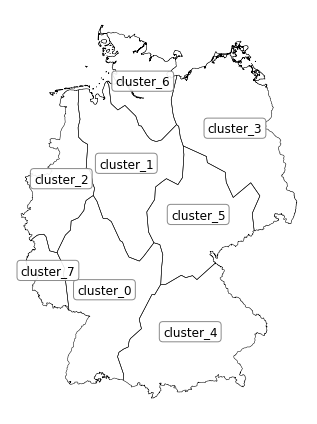

In [33]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [34]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                     
Biogas purchase              TAC         [1e9 Euro/a]                  0.264223   
                             commodCosts [1e9 Euro/a]                  0.264223   
                             operation   [GW$_{biogas,LHV}$*h/a]    4884.879301   
                                         [GW$_{biogas,LHV}$*h]      4884.879301   
Electricity demand           operation   [GW$_{el}$*h/a]          133963.451433   
                                         [GW$_{el}$*h]            133963.451433   
Existing run-of-river plants TAC         [1e9 Euro/a]                  0.144316   
                             capacity    [GW$_{el}$]                   0.693828   
                             operation   [GW$_{el}$*h/a]            3167.329183   
                                         [GW$_{el}$*h]              3167.329183   
                             opexCap     [1e9 Euro/a]                  0.144316   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    15855.229091   
                                         [GW$_{H_{2},LHV}$*h]      15855.229091   
PV                           TAC         [1e9 Euro/a]                  3.093173   
                             capacity    [GW$_{el}$]                  41.861175   
                             capexCap    [1e9 Euro/a]                  2.548977   
                             invest      [1e9 Euro]                   27.209764   
                             operation   [GW$_{el}$*h/a]           39723.206425   
                                         [GW$_{el}$*h]             39723.206425   
                             opexCap     [1e9 Euro/a]                  0.544195   
Wind (offshore)              TAC         [1e9 Euro/a]                       0.0   
                             capacity    [GW$_{el}$]                        NaN   
                             capexCap    [1e9 Euro/a]                       NaN   
                             invest      [1e9 Euro]                         NaN   
                             operation   [GW$_{el}$*h/a]                    NaN   
                                         [GW$_{el}$*h]                      NaN   
                             opexCap     [1e9 Euro/a]                       NaN   
Wind (onshore)               TAC         [1e9 Euro/a]                       0.0   
                             capacity    [GW$_{el}$]                        0.0   
                             capexCap    [1e9 Euro/a]                       0.0   
                             invest      [1e9 Euro]                         0.0   
                             operation   [GW$_{el}$*h/a]                    0.0   
                                         [GW$_{el}$*h]                      0.0   
                             opexCap     [1e9 Euro/a]                       0.0   

                                                                     cluster_1  \
Component                    Property    Unit                                    
Biogas purchase              TAC         [1e9 Euro/a]                 0.253751   
                             commodCosts [1e9 Euro/a]                 0.253751   
                             operation   [GW$_{biogas,LHV}$*h/a]   4691.281527   
                                         [GW$_{biogas,LHV}$*h]     4691.281527   
Electricity demand           operation   [GW$_{el}$*h/a]          66115.987455   
                                         [GW$_{el}$*h]            66115.987455   
Existing run-of-river plants TAC         [1e9 Euro/a]                 0.007791   
                             capacity    [GW$_{el}$]                  0.037456   
                             operation   [GW$_{el}$*h/a]            170.988002   
                                         [GW$_{el}$*h]              170.988002   
                             opexCap     [1e9 Euro/a]                 0.007791   
Hydrogen demand

Plot installed capacities

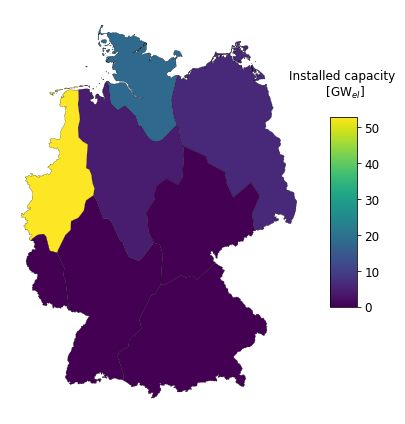

In [35]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (offshore)', locFilePath, 'index', perArea=False)

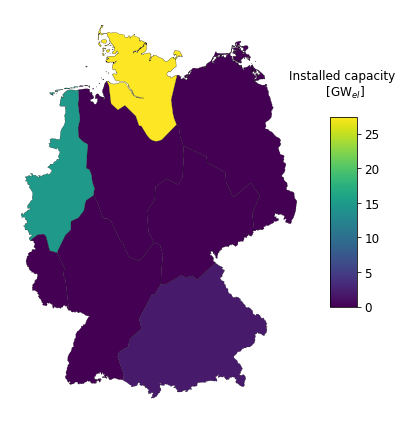

In [36]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (onshore)', locFilePath, 'index', perArea=False)

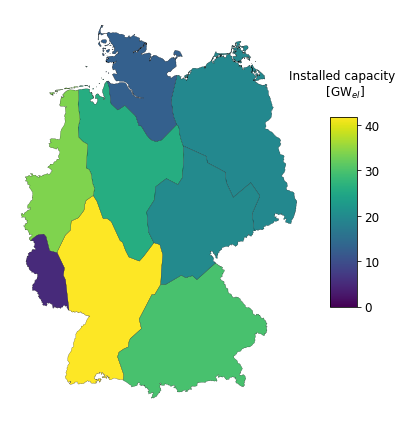

In [37]:
fig, ax = fn.plotLocationalColorMap(esM, 'PV', locFilePath, 'index', perArea=False)

Plot operation time series (either one or two dimensional)

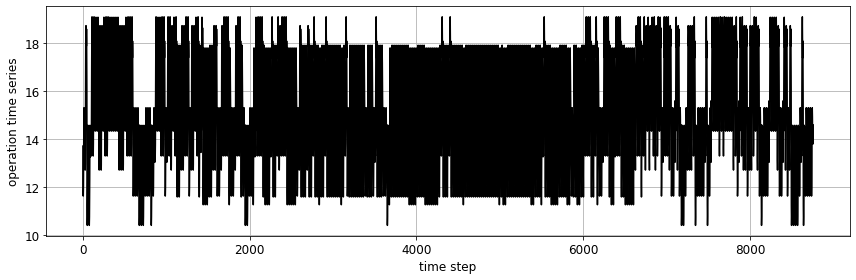

In [38]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

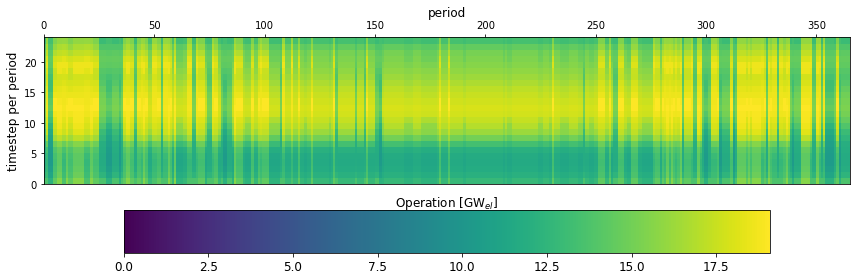

In [39]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [40]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0    cluster_1  \
Component                Property  Unit                                        
Electrolyzer             TAC       [1e9 Euro/a]        0.007335     0.082795   
                         capacity  [GW$_{el}$]         0.084298      0.95151   
                         capexCap  [1e9 Euro/a]        0.006281     0.070901   
                         invest    [1e9 Euro]          0.042149     0.475755   
                         operation [GW$_{el}$*h/a]   275.739992   3055.17108   
                                   [GW$_{el}$*h]     275.739992   3055.17108   
                         opexCap   [1e9 Euro/a]        0.001054     0.011894   
New CCGT plants (biogas) TAC       [1e9 Euro/a]        0.057472     0.232213   
                         capacity  [GW$_{el}$]          0.70262     2.838928   
                         capexCap  [1e9 Euro/a]        0.042717     0.172596   
                         invest    [1e9 Euro]          0.491834      1.98725   
                         operation [GW$_{el}$*h/a]  1266.823185  4875.826629   
                                   [GW$_{el}$*h]    1266.823185  4875.826629   
                         opexCap   [1e9 Euro/a]        0.014755     0.059617   

                                                       cluster_2    cluster_3  \
Component                Property  Unit                                         
Electrolyzer             TAC       [1e9 Euro/a]         0.543649     0.129856   
                         capacity  [GW$_{el}$]          6.247785      1.49234   
                         capexCap  [1e9 Euro/a]         0.465552     0.111201   
                         invest    [1e9 Euro]           3.123893      0.74617   
                         operation [GW$_{el}$*h/a]  25436.583509  5992.788544   
                                   [GW$_{el}$*h]    25436.583509  5992.788544   
                         opexCap   [1e9 Euro/a]         0.078097     0.018654   
New CCGT plants (biogas) TAC       [1e9 Euro/a]         0.310053     0.135068   
                         capacity  [GW$_{el}$]          3.790555     1.651282   
                         capexCap  [1e9 Euro/a]         0.230451     0.100392   
                         invest    [1e9 Euro]           2.653388     1.155897   
                         operation [GW$_{el}$*h/a]   6770.615692  2843.819679   
                                   [GW$_{el}$*h]     6770.615692  2843.819679   
                         opexCap   [1e9 Euro/a]         0.079602     0.034677   

                                                      cluster_4    cluster_5  \
Component                Property  Unit                                        
Electrolyzer             TAC       [1e9 Euro/a]        0.087079     0.177983   
                         capacity  [GW$_{el}$]         1.000736     2.045436   
                         capexCap  [1e9 Euro/a]         0.07457     0.152415   
                         invest    [1e9 Euro]          0.500368     1.022718   
                         operation [GW$_{el}$*h/a]  3368.478616  8210.605103   
                                   [GW$_{el}$*h]    3368.478616  8210.605103   
                         opexCap   [1e9 Euro/a]        0.012509     0.025568   
New CCGT plants (biogas) TAC       [1e9 Euro/a]        0.076445     0.086687   
                         capacity  [GW$_{el}$]         0.934579     1.059793   
                         capexCap  [1e9 Euro/a]        0.056819     0.064431   
                         invest    [1e9 Euro]          0.654205     0.741855   
                         operation [GW$_{el}$*h/a]  1646.672583  1812.245462   
                                   [GW$_{el}$*h]    1646.672583  1812.245462   
                         opexCap   [1e9 Euro/a]        0.019626     0.022256   

                                                       cluster_6   cluster_7  
Component                Property  Unit                                       
Electrolyzer             TAC       [1

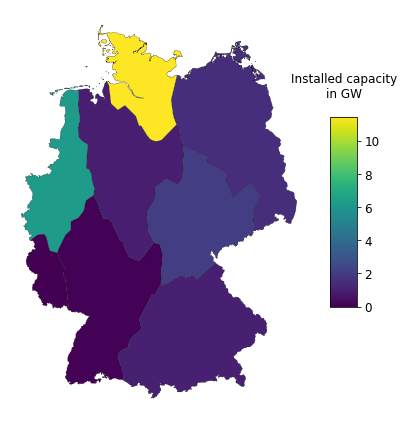

In [41]:
fig, ax = fn.plotLocationalColorMap(esM, 'Electrolyzer', locFilePath, 'index', perArea=False, zlabel='Installed capacity\nin GW\n')

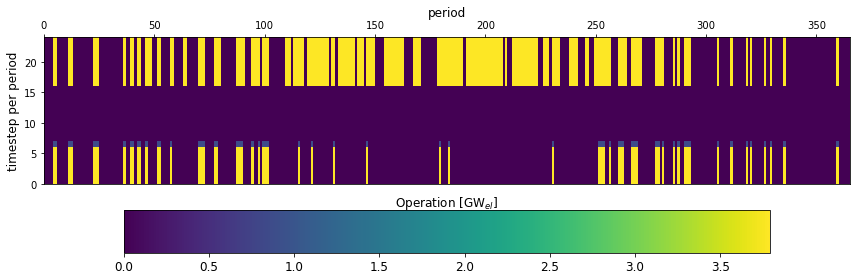

In [42]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

### Storage

Show optimization summary

In [43]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                   
Li-ion batteries        TAC                [1e9 Euro/a]                0.149507   
                        capacity           [GW$_{el}$*h]               8.897699   
                        capexCap           [1e9 Euro/a]                0.131711   
                        invest             [1e9 Euro]                  1.343553   
                        operationCharge    [GW$_{el}$*h/a]          2880.497253   
                                           [GW$_{el}$*h]            2880.497253   
                        operationDischarge [GW$_{el}$*h/a]          2598.582767   
                                           [GW$_{el}$*h]            2598.582767   
                        opexCap            [1e9 Euro/a]                0.017795   
Pumped hydro storage    TAC                [1e9 Euro/a]                0.002436   
                        capacity           [GW$_{el}$*h]                 15.924   
                        operationCharge    [GW$_{el}$*h/a]          7072.200813   
                                           [GW$_{el}$*h]            7072.200813   
                        operationDischarge [GW$_{el}$*h/a]          5476.540513   
                                           [GW$_{el}$*h]            5476.540513   
                        opexCap            [1e9 Euro/a]                0.002436   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                     0.0   
                        capacity           [GW$_{biogas,LHV}$*h]            NaN   
                        capexCap           [1e9 Euro/a]                     NaN   
                        invest             [1e9 Euro]                       NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]          NaN   
                                           [GW$_{biogas,LHV}$*h]            NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]          NaN   
                                           [GW$_{biogas,LHV}$*h]            NaN   
                        opexCap            [1e9 Euro/a]                     NaN   
Salt caverns (hydrogen) TAC                [1e9 Euro/a]                     0.0   
                        capacity           [GW$_{H_{2},LHV}$*h]             NaN   
                        capexCap           [1e9 Euro/a]                     NaN   
                        invest             [1e9 Euro]                       NaN   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]           NaN   
                                           [GW$_{H_{2},LHV}$*h]             NaN   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]           NaN   
                                           [GW$_{H_{2},LHV}$*h]             NaN   
                        opexCap            [1e9 Euro/a]                     NaN   

                                                                      cluster_1  \
Component               Property           Unit                                   
Li-ion batteries        TAC                [1e9 Euro/a]                 0.41005   
                        capacity           [GW$_{el}$*h]              24.403627   
                        capexCap           [1e9 Euro/a]                0.361243   
                        invest             [1e9 Euro]                  3.684948   
                        operationCharge    [GW$_{el}$*h/a]          8989.713664   
                                           [GW$_{el}$*h]            8989.713664   
                        operationDischarge [GW$_{el}$*h/a]          8109.957569   
                                           [GW$_{el}$*h]            8109.957569   
                        opexCap            [1e9 Euro/a]                0.048807   
Pumped hydro storage    TAC                [1e9 Euro/a]                0.001186   
                        capacity           [GW$_{el}$*h]                  7.751   
  

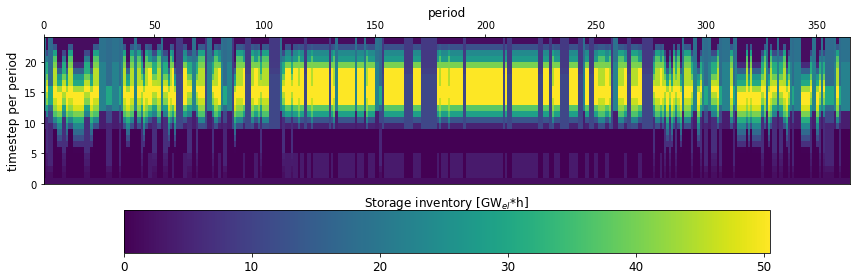

In [44]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

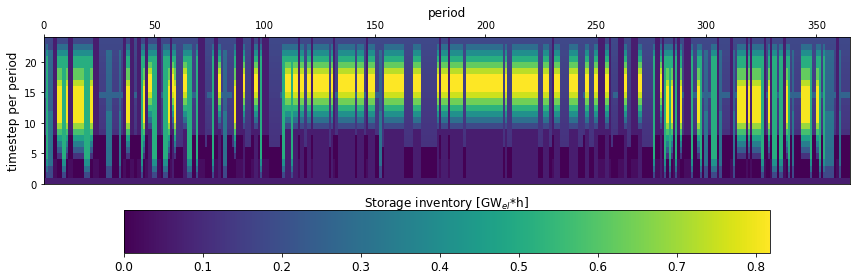

In [45]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

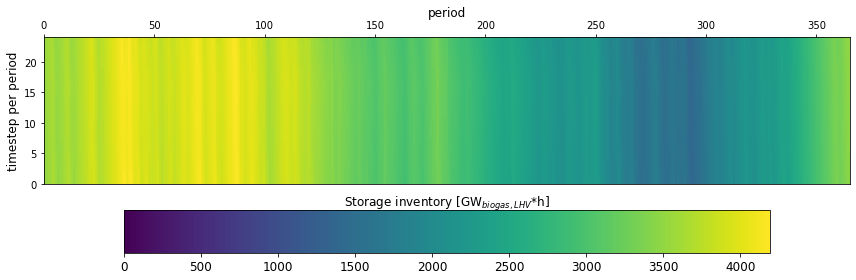

In [46]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

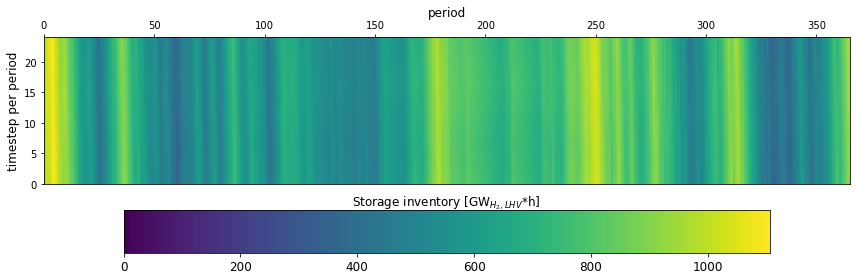

In [47]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [48]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc['Pipelines (hydrogen)']

cluster_0    cluster_1  \
Property     Unit                   LocationIn                              
TAC          [1e9 Euro/a]           cluster_0            0.0     0.013249   
                                    cluster_1       0.013249          0.0   
                                    cluster_2            0.0          0.0   
                                    cluster_3            0.0          0.0   
                                    cluster_4       0.006892          0.0   
                                    cluster_6            0.0     0.015668   
                                    cluster_7            0.0          0.0   
capacity     [GW$_{H_{2},LHV}$]     cluster_0            NaN     2.960445   
                                    cluster_1       2.960445          NaN   
                                    cluster_2            0.0          0.0   
                                    cluster_3            NaN          0.0   
                                    cluster_4       1.150487          NaN   
                                    cluster_6            NaN     5.057461   
                                    cluster_7            0.0          NaN   
capexCap     [1e9 Euro/a]           cluster_0            NaN     0.008129   
                                    cluster_1       0.008129          NaN   
                                    cluster_2            0.0          0.0   
                                    cluster_3            NaN          0.0   
                                    cluster_4        0.00263          NaN   
                                    cluster_6            NaN     0.011448   
                                    cluster_7            0.0          NaN   
capexIfBuilt [1e9 Euro/a]           cluster_0            NaN      0.00512   
                                    cluster_1        0.00512          NaN   
                                    cluster_2            0.0          0.0   
                                    cluster_3            NaN          0.0   
                                    cluster_4       0.004262          NaN   
                                    cluster_6            NaN      0.00422   
                                    cluster_7            0.0          NaN   
invest       [1e9 Euro]             cluster_0            NaN      0.15799   
                                    cluster_1        0.15799          NaN   
                                    cluster_2            0.0          0.0   
                                    cluster_3            NaN          0.0   
                                    cluster_4        0.08218          NaN   
                                    cluster_6            NaN     0.186839   
                                    cluster_7            0.0          NaN   
isBuilt      [-]                    cluster_0            NaN          1.0   
                                    cluster_1            1.0          NaN   
                                    cluster_2            0.0          0.0   
                                    cluster_3            NaN          0.0   
                                    cluster_4            1.0          NaN   
                                    cluster_6            NaN          1.0   
                                    cluster_7            0.0          NaN   
operation    [GW$_{H_{2},LHV}$*h/a] cluster_0            NaN  1252.177821   
                                    cluster_1   24634.721412          NaN   
                                    cluster_2            0.0          0.0   
                                    cluster_3            NaN          0.0   
                                    cluster_6            NaN  32293.00588   
                                    cluster_7            0.0          NaN   
             [GW$_{H_{2},LHV}$*h]   cluster_0            NaN  1252.177821   
                                    cluster_1   24634.721412          NaN   
                                    cluster_2  

Check that the shared capacity of the pipelines are not exceeded

In [49]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,2.960445,1.299364,NaN,1.892217,0.0,NaN,0.000000
cluster_1,2.960445,NaN,0.000000,0.000000,NaN,0.0,5.405421,NaN
cluster_2,1.299364,0.000000,NaN,NaN,NaN,NaN,NaN,0.305141
cluster_3,NaN,0.000000,NaN,NaN,NaN,0.0,0.211877,NaN
cluster_4,1.892217,NaN,NaN,NaN,NaN,0.0,NaN,NaN
cluster_5,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
cluster_6,NaN,5.405421,NaN,0.211877,NaN,NaN,NaN,NaN
cluster_7,0.000000,NaN,0.305141,NaN,NaN,NaN,NaN,NaN


Plot installed transmission capacities

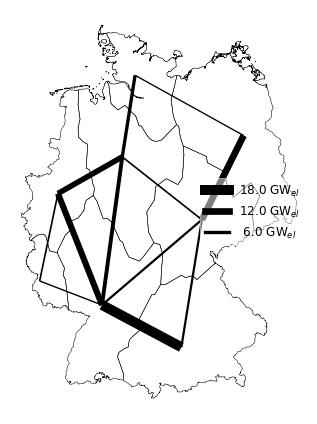

In [50]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

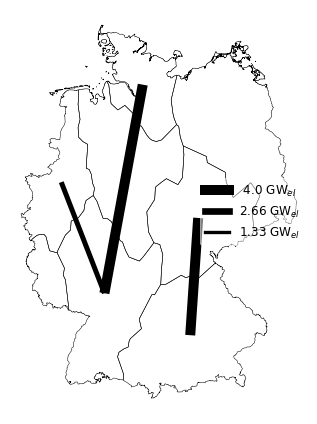

In [51]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

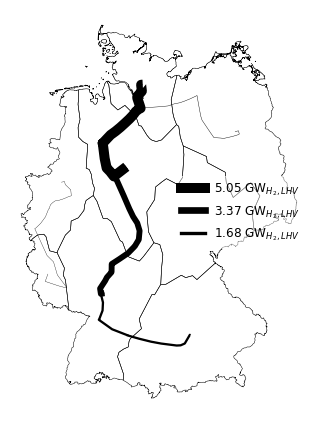

In [52]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='loc1', loc1='loc2',
                              fig=fig, ax=ax)

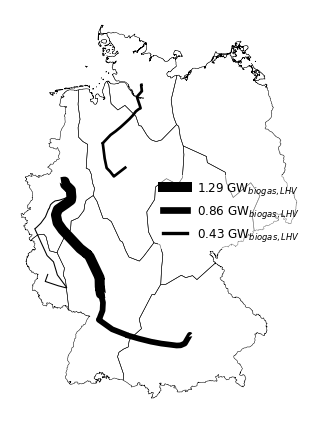

In [53]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='loc1', loc1='loc2',
                              fig=fig, ax=ax)